# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [1]:
import tensorflow as tf
import keras
from keras.layers import *
from keras.models import Model
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from PIL import Image
import seaborn as sns
sns.set(font_scale=1.1, rc={
    'figure.figsize': (15, 10),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#333333',
    'xtick.color': '#666666',
    'ytick.color': '#666666'
})
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

In [3]:
image_dir = "/content/drive/MyDrive/ColabNotebooks/Coursework/data/"
image_dir_list = os.listdir(image_dir)

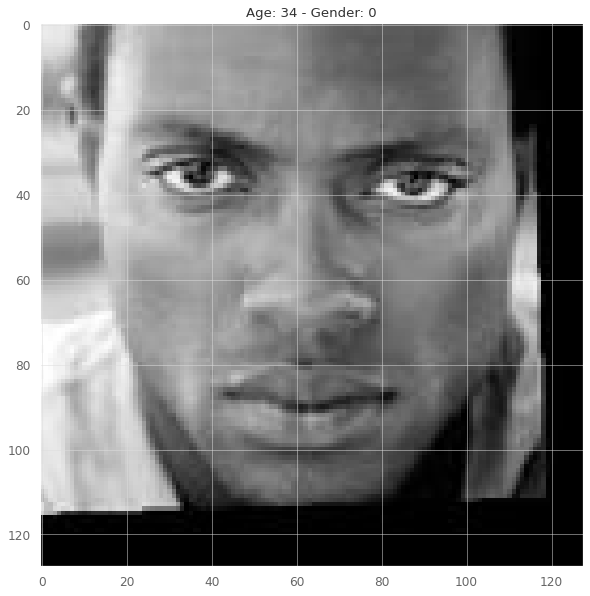

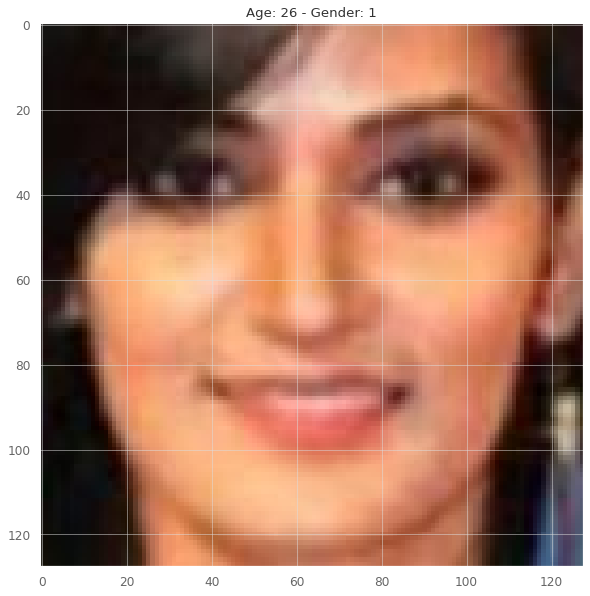

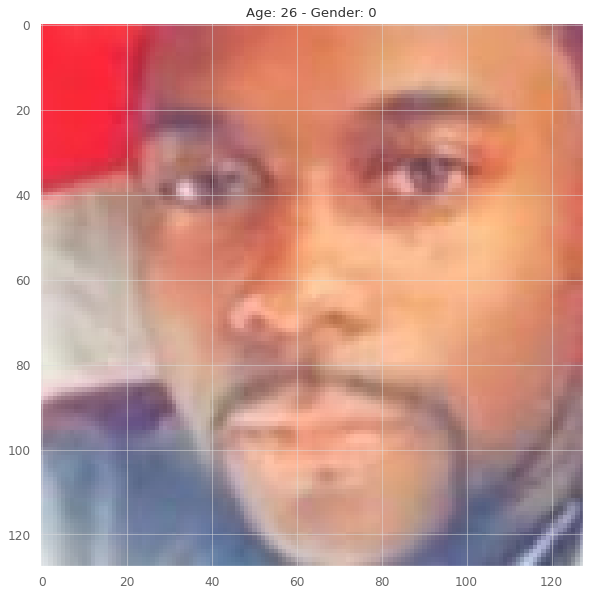

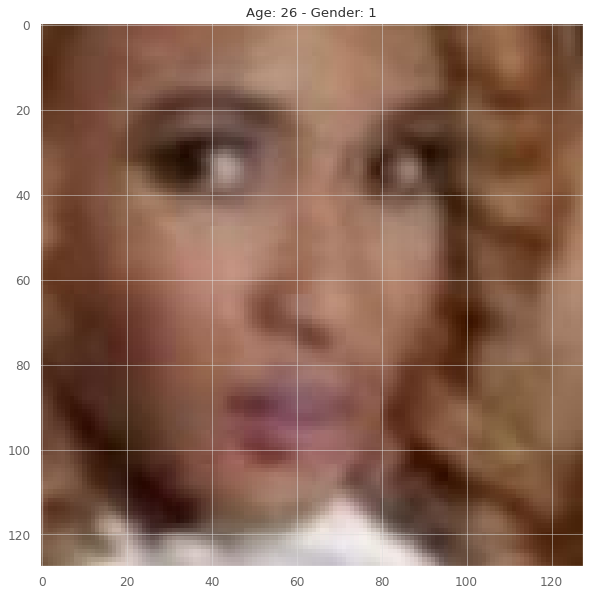

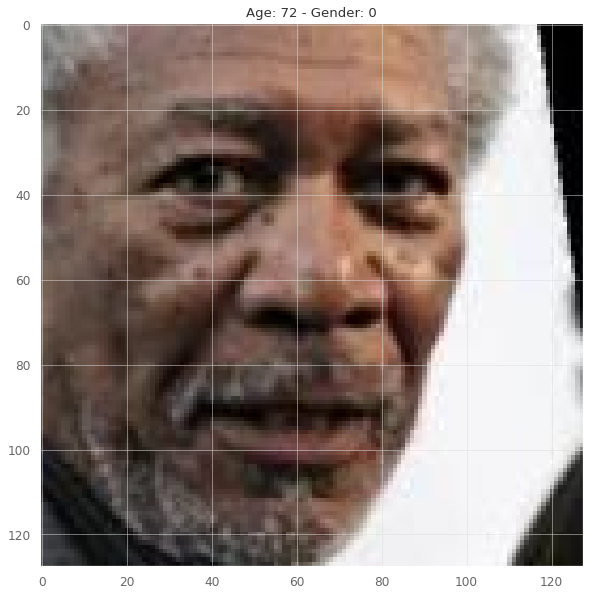

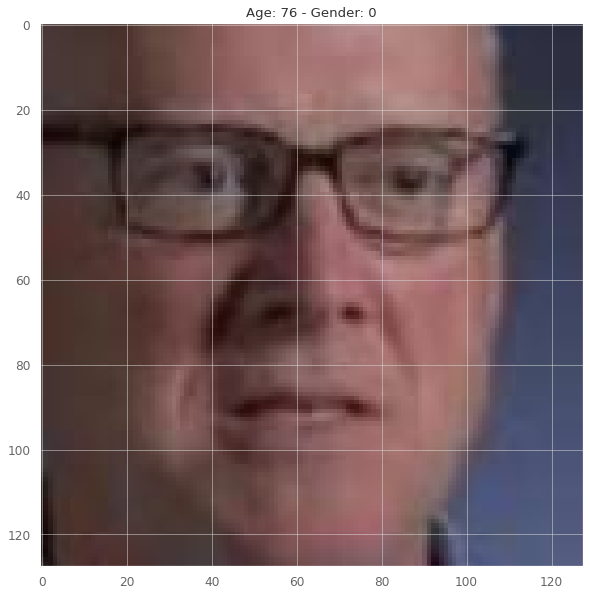

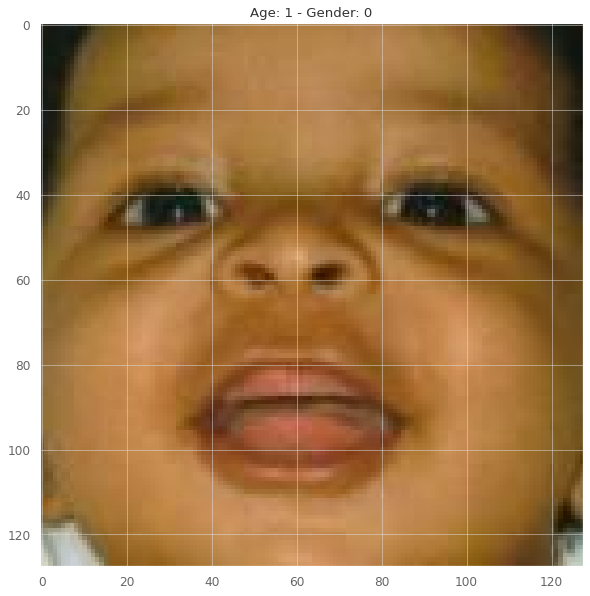

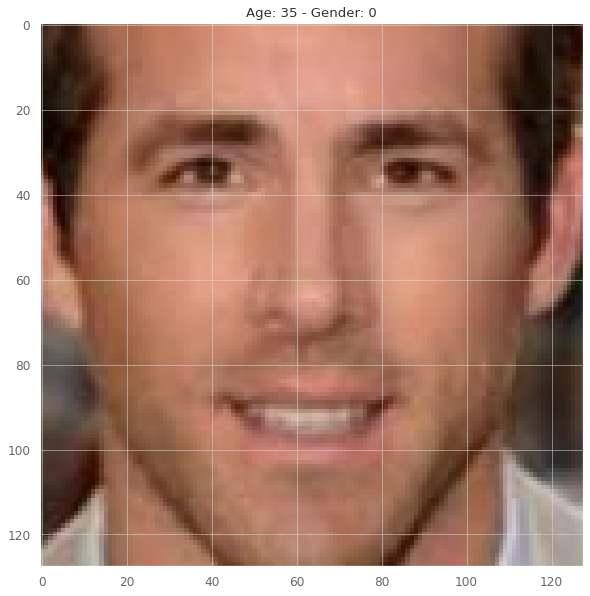

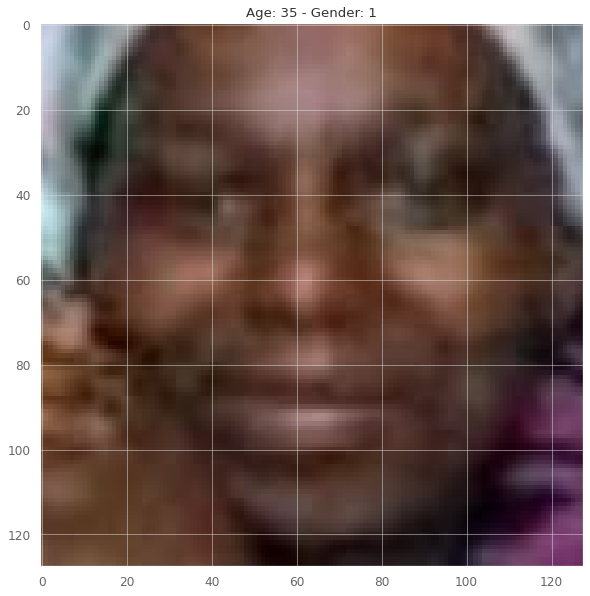

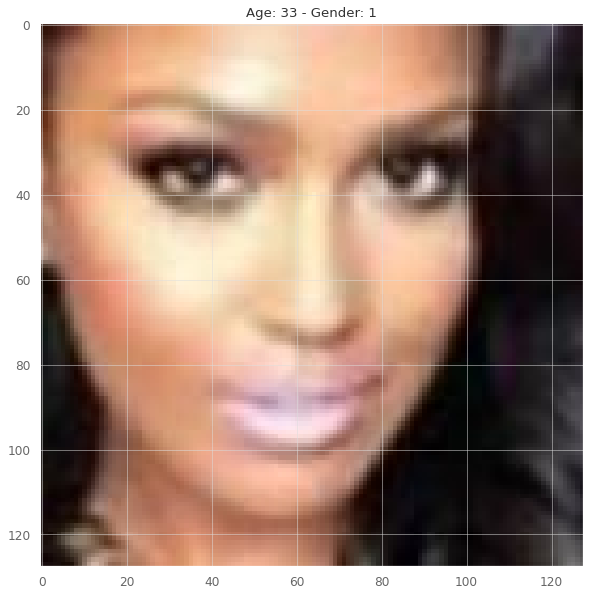

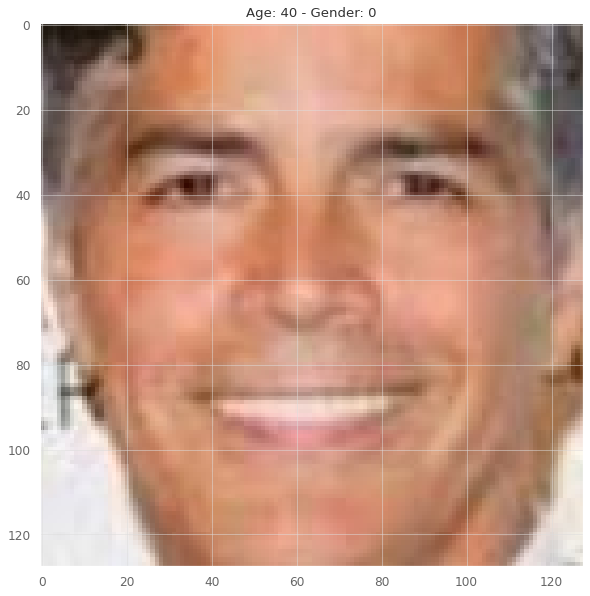

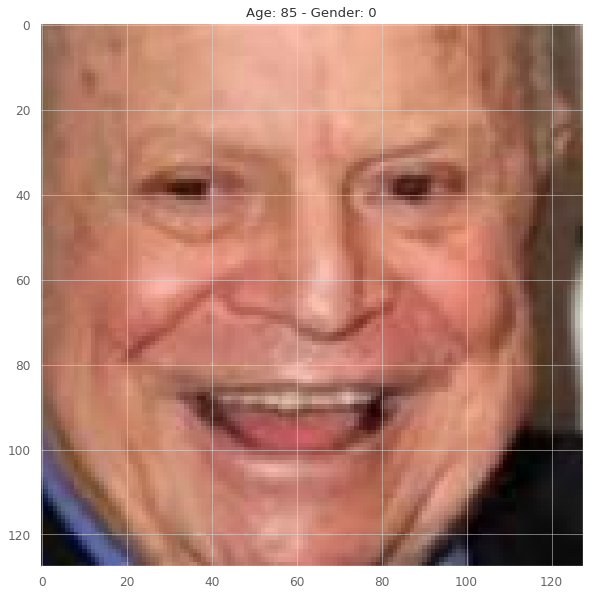

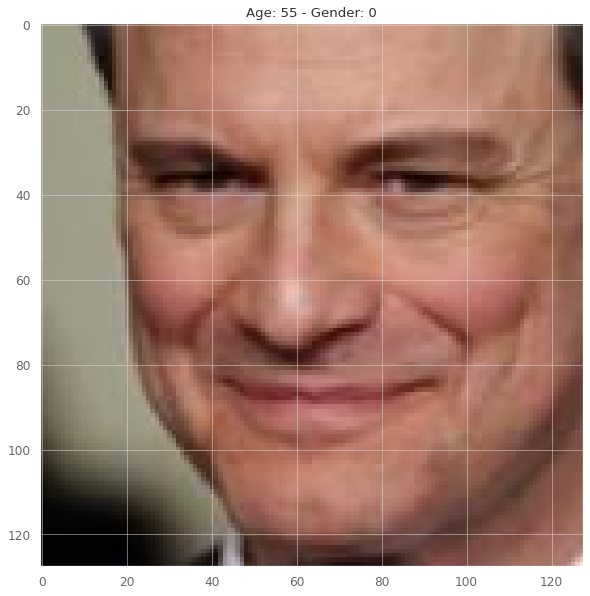

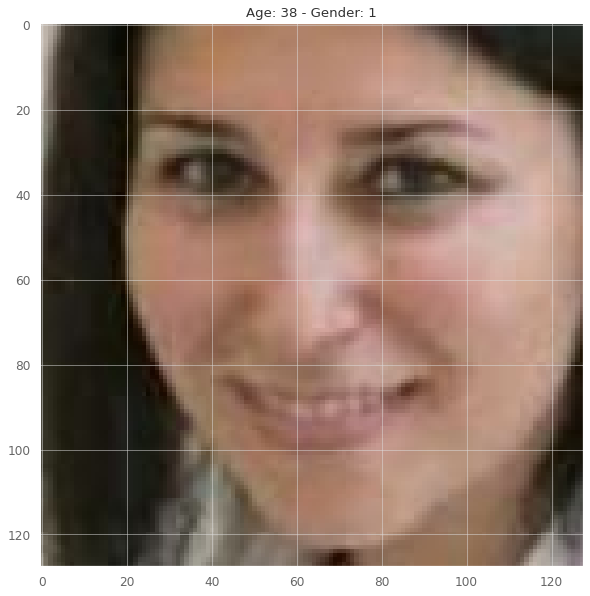

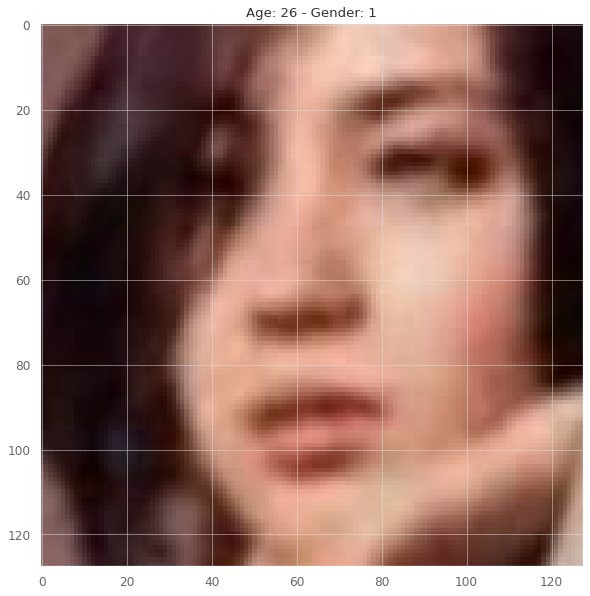

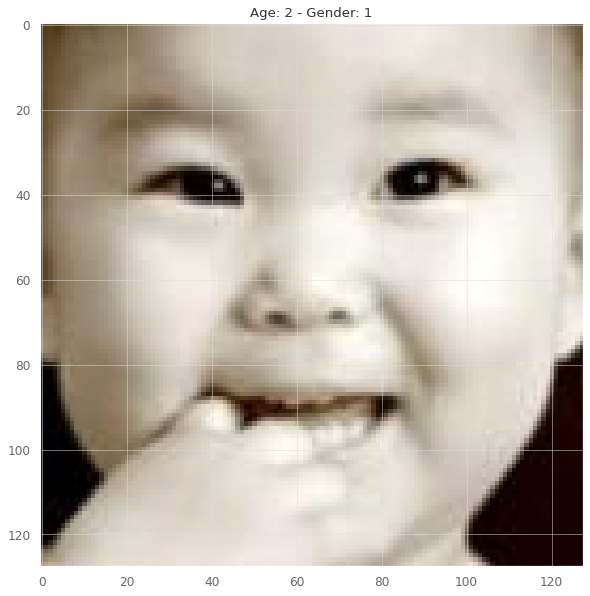

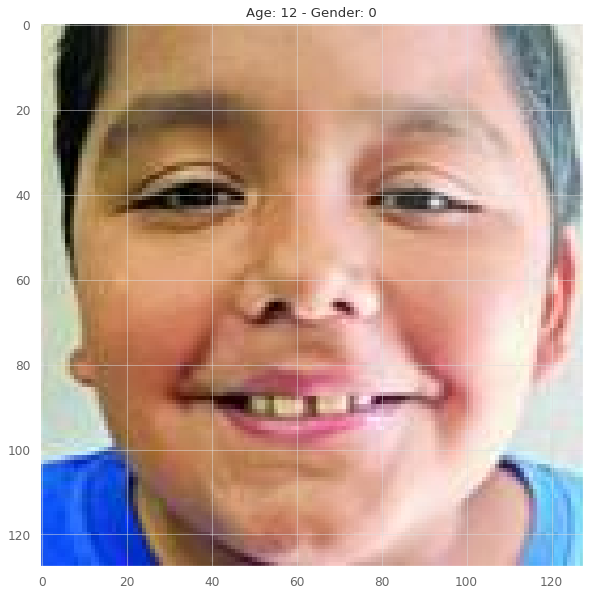

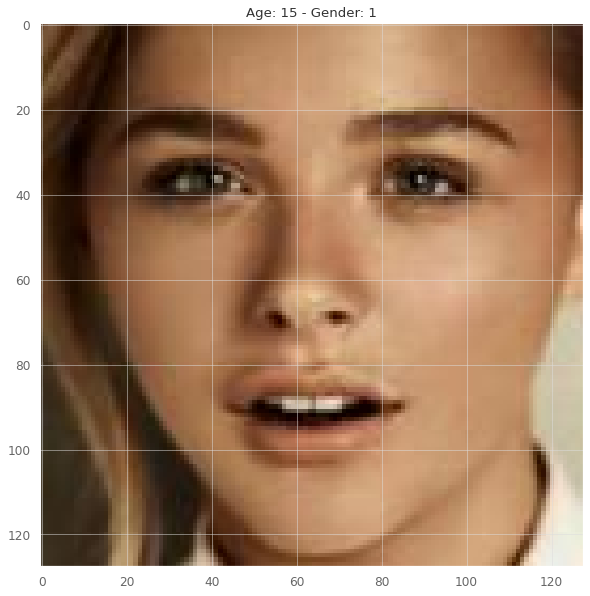

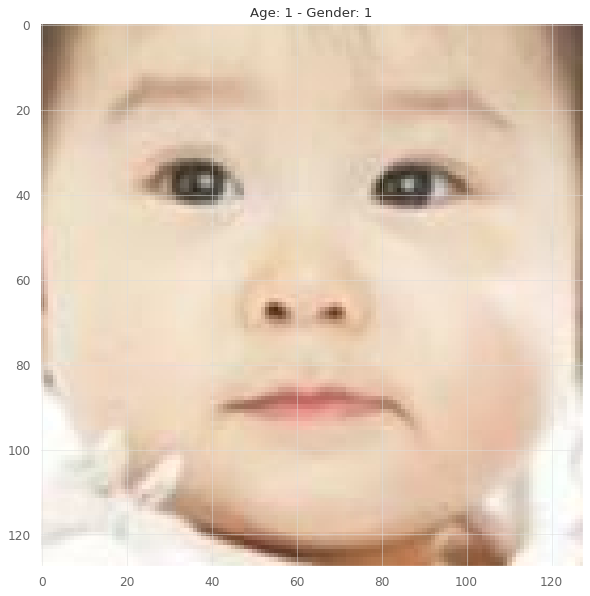

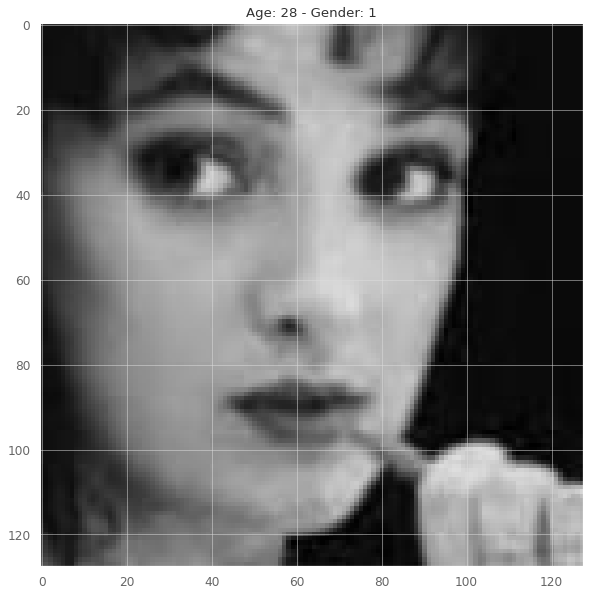

In [71]:
# Print 
i = 0
for image_name in image_dir_list:
  plt.figure(i)
  image = cv2.imread(image_dir + image_name)                                      
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                                  
  image = Image.fromarray(image, 'RGB') 
  plt.imshow(image)
  age = int(image_name.split('_')[0])
  gender = int(image_name.split('_')[1])
  plt.title(f'Age: {age} - Gender: {gender}')
  i += 1
  if i == 20:
    break
  
plt.show()


## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [7]:
input_shape = (128, 128, 3)                                                       # Image dimensions with 3 color channels

dataset = []
age_labels = []
gender_labels = []

for i, image_name in tqdm(enumerate(image_dir_list)):

  image = cv2.imread(image_dir + image_name)                                      # Read image
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                                  # Convert to RGB
  image = Image.fromarray(image, 'RGB')                                           # Convert to array with RGB channels

  dataset.append(np.array(image))                                                 # Append to dataset array as numpy array 

  age_labels.append(int(image_name.split('_')[0]))                                # Append labels taken from image name to label array
  gender_labels.append(int(image_name.split('_')[1]))

dataset = np.array(dataset)

5000it [00:11, 435.19it/s]


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [8]:
def rescale_images(images):
  return images / 255.0

dataset = rescale_images(dataset)

from keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

i = 0
augmented_images = []
for image in tqdm(image_datagen.flow(dataset,batch_size=1, shuffle=False)):
  augmented_images.append(image.reshape(128,128,3))
  age_labels.append(age_labels[i])
  gender_labels.append(gender_labels[i])
  i += 1
  if i == 2500:
      break

dataset = np.concatenate([dataset, augmented_images], axis=0)
del augmented_images # To save RAM

 50%|████▉     | 2499/5000 [00:10<00:10, 227.98it/s]


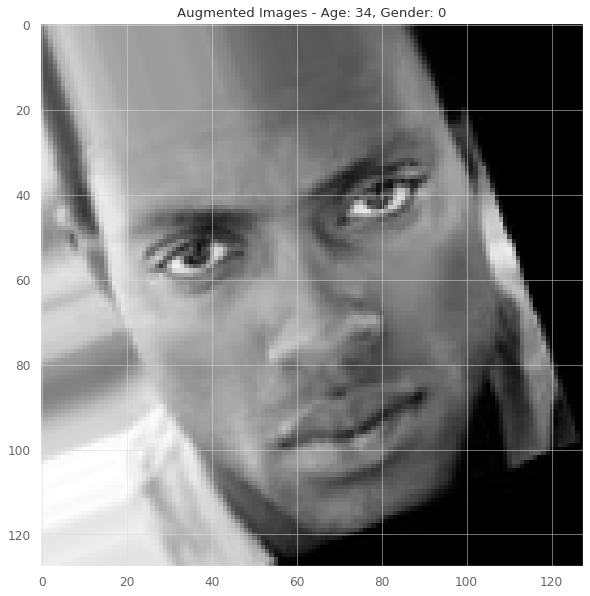

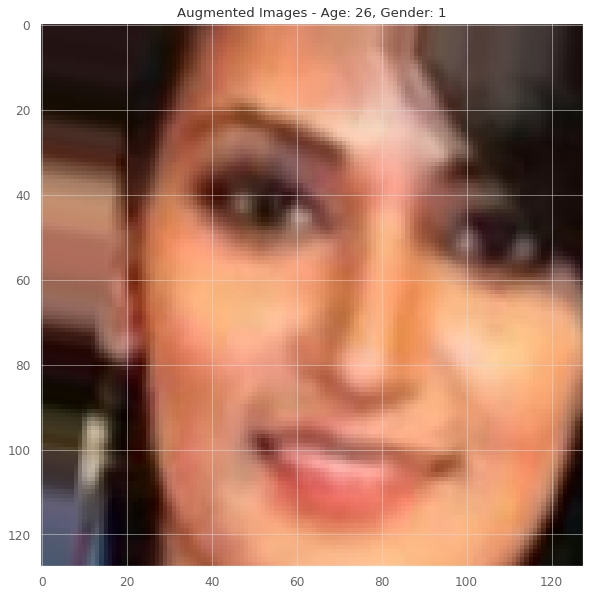

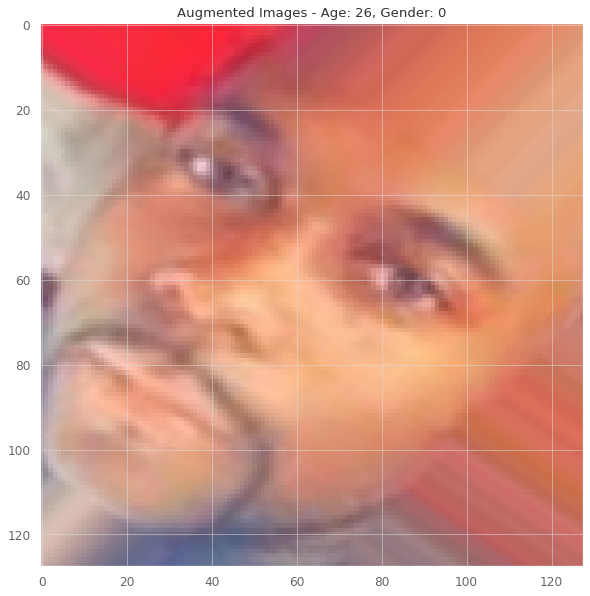

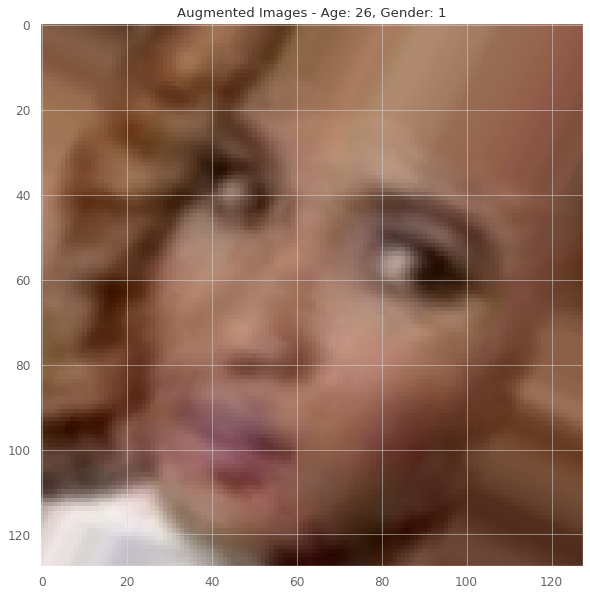

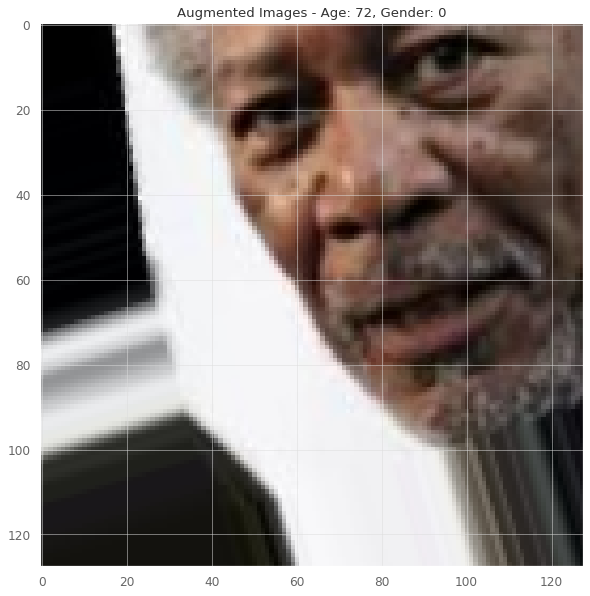

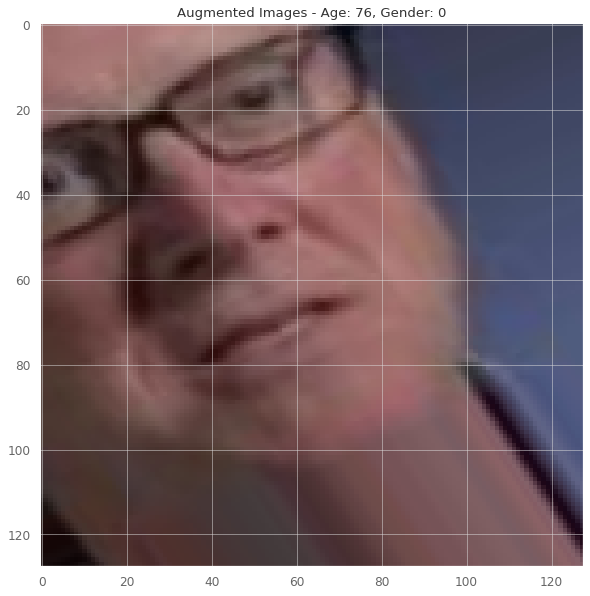

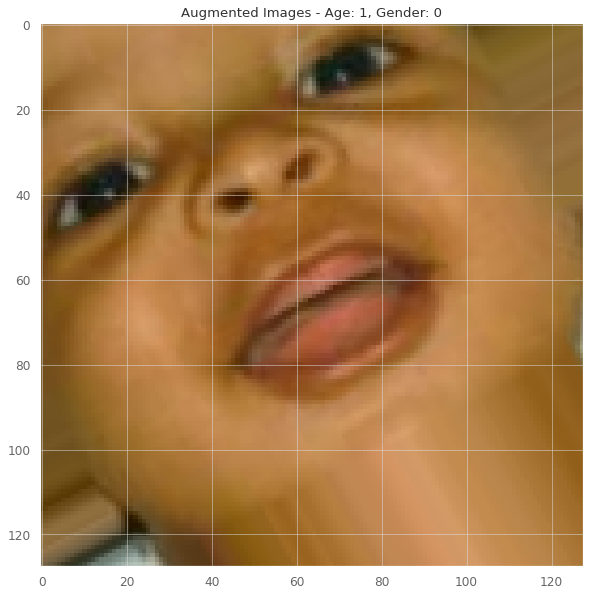

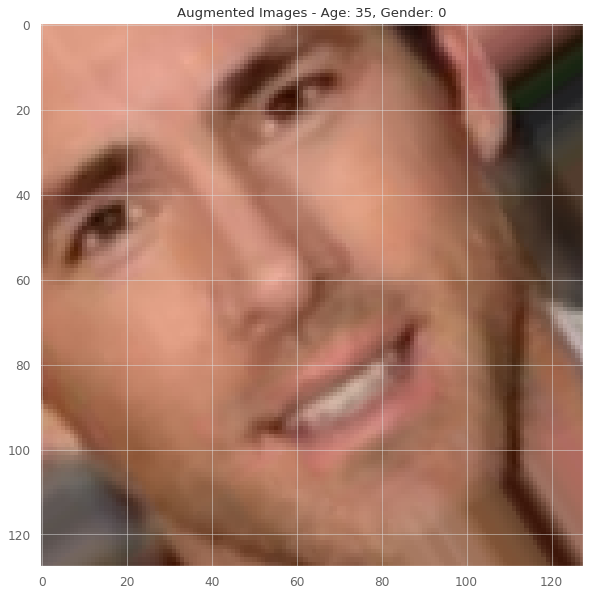

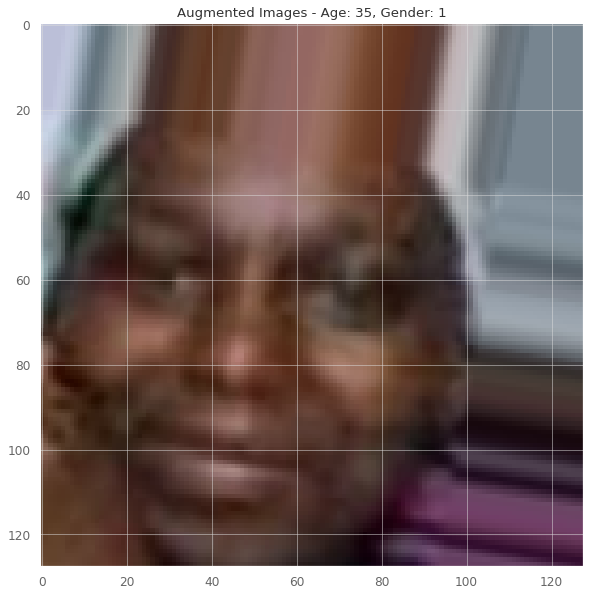

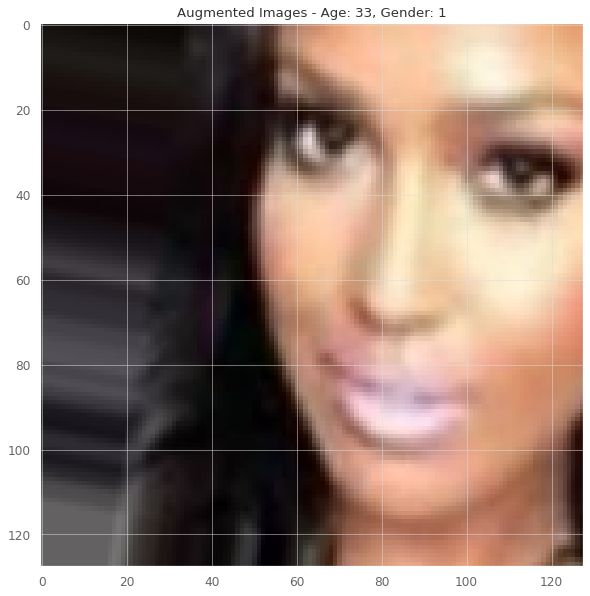

In [9]:
# Print 
for i in range(10):
  plt.figure(i)
  plt.imshow(dataset[i+5000])
  plt.title(f'Augmented Images - Age: {age_labels[i+5000]}, Gender: {gender_labels[i+5000]}')
plt.show()

In [33]:
# Split the data into training and validation sets
dataset, age_labels, gender_labels = map(np.array, (dataset, age_labels, gender_labels))
train_dataset, val_dataset, train_age_labels, val_age_labels, train_gender_labels, val_gender_labels = train_test_split(dataset, age_labels, gender_labels, test_size=0.2)

del dataset, age_labels, gender_labels # To save RAM

## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

In [ ]:
tf.compat.v1.reset_default_graph()

input_layer = Input(shape=input_shape)

# Age Branch

## Convolutional Block 1
block1_convolutional_layer1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
block1_max_pooling_layer1 = MaxPooling2D(pool_size=(2, 2))(block1_convolutional_layer1)
block1_normalisation_layer1 = BatchNormalization(axis = -1)(block1_max_pooling_layer1)
block1_dropout_layer1 = Dropout(rate=0.2)(block1_normalisation_layer1)

## Convolutional Block 2
block1_convolutional_layer2 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(block1_dropout_layer1)
block1_max_pooling_layer2 = MaxPooling2D(pool_size=(2, 2))(block1_convolutional_layer2)
block1_normalisation_layer2 = BatchNormalization(axis = -1)(block1_max_pooling_layer2)
block1_dropout_layer2 = Dropout(rate=0.2)(block1_normalisation_layer2)

block1_flatten_layer1 = Flatten()(block1_dropout_layer2) 

## Dense Block 1
block1_dense_layer1 = Dense(512, activation='relu')(block1_flatten_layer1)
block1_normalisation_layer3 = BatchNormalization(axis = -1)(block1_dense_layer1)
block1_dropout_layer3 = Dropout(rate=0.2)(block1_normalisation_layer3)

## Dense Block 2
block1_dense_layer2 = Dense(256, activation='relu')(block1_dropout_layer3)
block1_normalisation_layer4 = BatchNormalization(axis = -1)(block1_dense_layer2)
block1_dropout_layer4 = Dropout(rate=0.2)(block1_normalisation_layer4)

block1_output_layer = Dense(1, activation='linear', name='age_output')(block1_dropout_layer4)


# Gender Branch

## Convolutional Block 1
block2_convolutional_layer1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
block2_max_pooling_layer1 = MaxPooling2D(pool_size=(2, 2))(block2_convolutional_layer1)
block2_normalisation_layer1 = BatchNormalization(axis = -1)(block2_max_pooling_layer1)
block2_dropout_layer1 = Dropout(rate=0.2)(block2_normalisation_layer1)

## Convolutional Block 2
block2_convolutional_layer2 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(block2_dropout_layer1)
block2_max_pooling_layer2 = MaxPooling2D(pool_size=(2, 2))(block2_convolutional_layer2)
block2_normalisation_layer2 = BatchNormalization(axis = -1)(block2_max_pooling_layer2)
block2_dropout_layer2 = Dropout(rate=0.2)(block2_normalisation_layer2)

block2_flatten_layer1 = Flatten()(block2_dropout_layer2) 

## Dense Block 1
block2_dense_layer1 = Dense(512, activation='relu')(block2_flatten_layer1)
block2_normalisation_layer3 = BatchNormalization(axis = -1)(block2_dense_layer1)
block2_dropout_layer3 = Dropout(rate=0.2)(block2_normalisation_layer3)

## Dense Block 2
block2_dense_layer2 = Dense(256, activation='relu')(block2_dropout_layer3)
block2_normalisation_layer4 = BatchNormalization(axis = -1)(block2_dense_layer2)
block2_dropout_layer4 = Dropout(rate=0.2)(block2_normalisation_layer4)

block2_output_layer = Dense(1, activation='sigmoid', name='gender_output')(block2_dropout_layer4)



model = tf.keras.Model(inputs=input_layer, outputs=[block1_output_layer, block2_output_layer])
model.compile(optimizer='adam', loss={'age_output':'mae', 'gender_output':'binary_crossentropy'}, metrics={'age_output':'mae', 'gender_output':'accuracy'})

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [ ]:
# Train the model using the training set
history = model.fit(train_dataset, [train_age_labels, train_gender_labels], batch_size=8, verbose=1, epochs=30, validation_data=(val_dataset, [val_age_labels, val_gender_labels]))

Epoch 1/30
500/500 [==============================] - 20s 22ms/step - loss: 22.4167 - age_output_loss: 21.8002 - gender_output_loss: 0.6165 - age_output_mae: 21.8002 - gender_output_accuracy: 0.7163 - val_loss: 13.9378 - val_age_output_loss: 13.3047 - val_gender_output_loss: 0.6331 - val_age_output_mae: 13.3047 - val_gender_output_accuracy: 0.6740
Epoch 2/30
500/500 [==============================] - 10s 21ms/step - loss: 13.1447 - age_output_loss: 12.6664 - gender_output_loss: 0.4783 - age_output_mae: 12.6664 - gender_output_accuracy: 0.7788 - val_loss: 11.7908 - val_age_output_loss: 11.3909 - val_gender_output_loss: 0.3999 - val_age_output_mae: 11.3909 - val_gender_output_accuracy: 0.8210
Epoch 3/30
500/500 [==============================] - 10s 21ms/step - loss: 12.7266 - age_output_loss: 12.3053 - gender_output_loss: 0.4212 - age_output_mae: 12.3053 - gender_output_accuracy: 0.8095 - val_loss: 11.3425 - val_age_output_loss: 10.9071 - val_gender_output_loss: 0.4354 - val_age_output_

In [ ]:
model.save("/content/drive/MyDrive/ColabNotebooks/Coursework/age_gender_A.h5")

In [ ]:
model.summary()

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


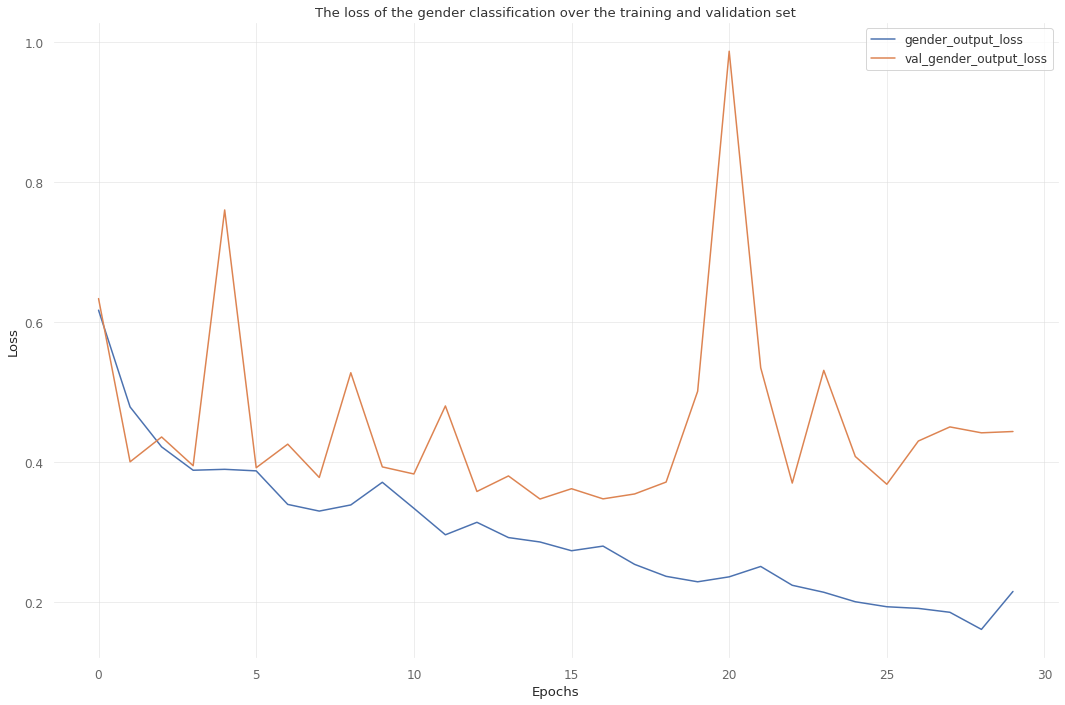

In [ ]:
plt.plot(history.history["gender_output_loss"])
plt.plot(history.history["val_gender_output_loss"])
plt.legend(['gender_output_loss', 'val_gender_output_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("The loss of the gender classification over the training and validation set")
plt.tight_layout()

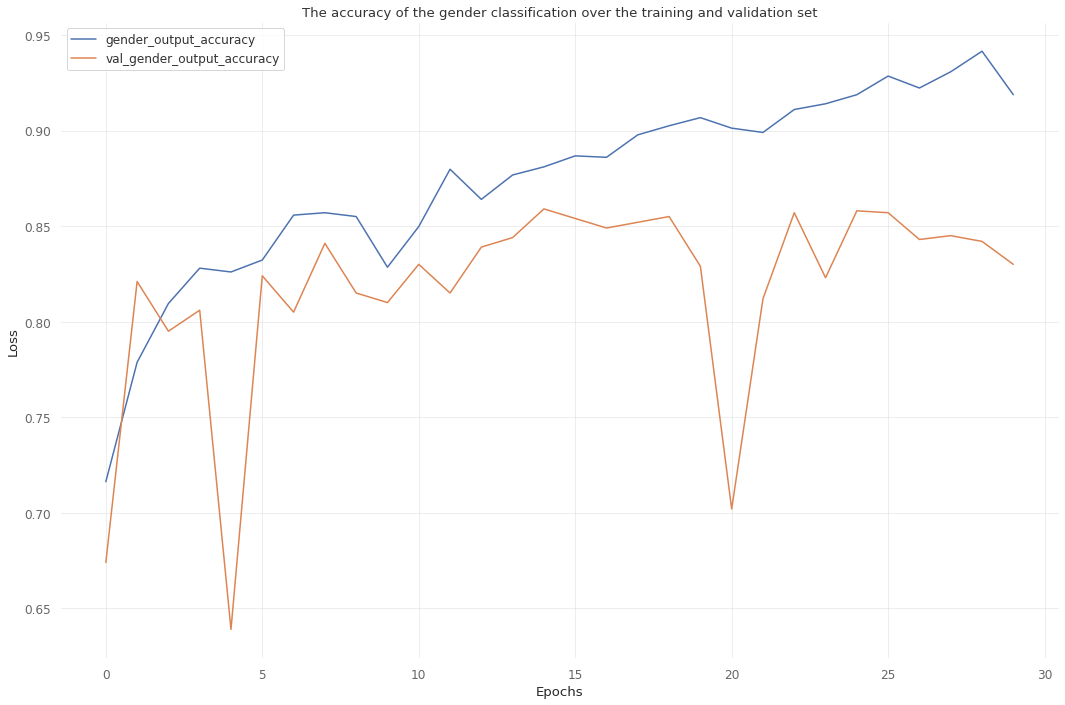

In [ ]:
plt.plot(history.history["gender_output_accuracy"])
plt.plot(history.history["val_gender_output_accuracy"])
plt.legend(['gender_output_accuracy', 'val_gender_output_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("The accuracy of the gender classification over the training and validation set")
plt.tight_layout()

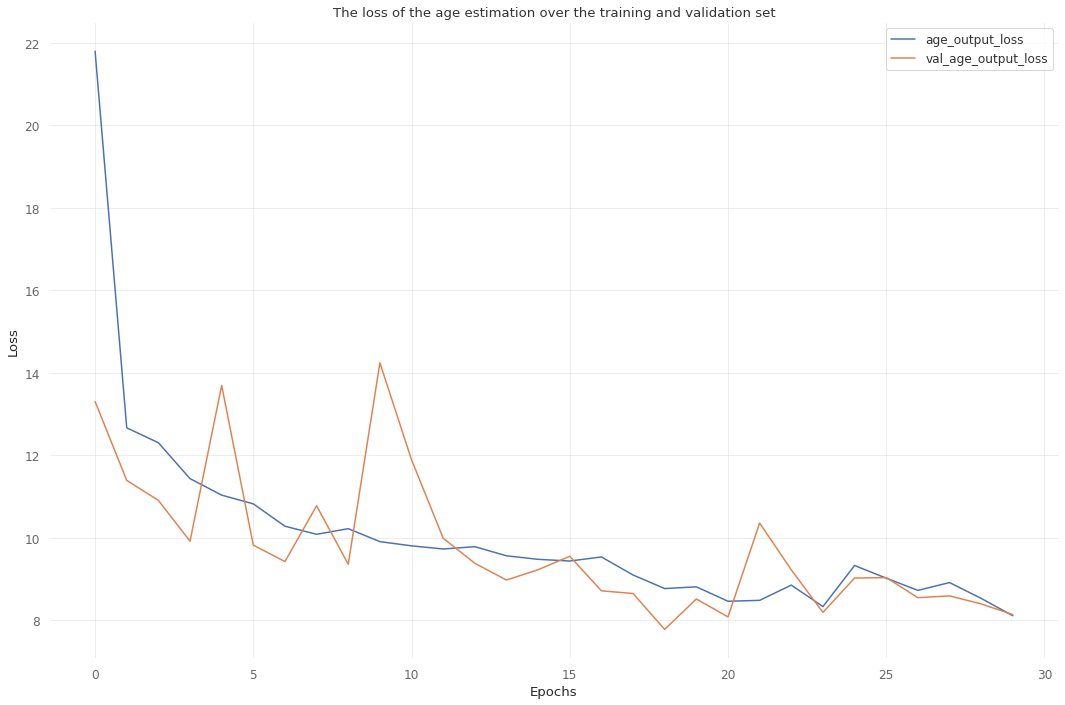

In [ ]:
plt.plot(history.history["age_output_loss"])
plt.plot(history.history["val_age_output_loss"])
plt.legend(['age_output_loss', 'val_age_output_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("The loss of the age estimation over the training and validation set")
plt.tight_layout()

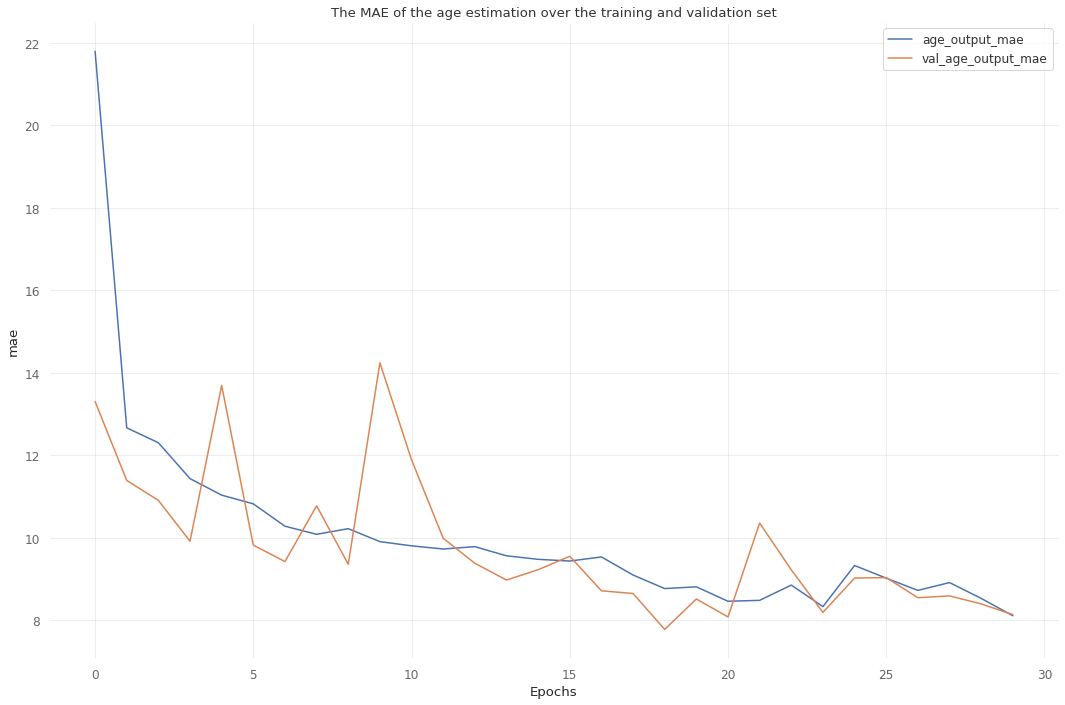

In [ ]:
plt.plot(history.history["age_output_mae"])
plt.plot(history.history["val_age_output_mae"])
plt.legend(['age_output_mae', 'val_age_output_mae'])
plt.xlabel("Epochs")
plt.ylabel("mae")
plt.title("The MAE of the age estimation over the training and validation set")
plt.tight_layout()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


In [28]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [49]:
tf.compat.v1.reset_default_graph()

inputs = Input(shape=input_shape)
rescaled_input = Rescaling(255, name='Rescaling_Input')(inputs)

# Age Branch
age_branch = EfficientNetB0(include_top=False, input_tensor=rescaled_input, weights="imagenet")
## Freeze the pretrained weights
age_branch.trainable = False

## Rebuild top
branch1_globalpooling_layer1 = GlobalAveragePooling2D()(age_branch.output)
branch1_batch_norm_layer1 = BatchNormalization()(branch1_globalpooling_layer1)

branch1_dropout_layer1 = Dropout(0.2)(branch1_batch_norm_layer1)
age_branch_output = Dense(1, activation="linear", name="age_output")(branch1_dropout_layer1)

# Gender Branch
gender_branch = EfficientNetB0(include_top=False, input_tensor=rescaled_input, weights="imagenet")
## Freeze the pretrained weights
gender_branch.trainable = False

## Rebuild top
branch2_globalpooling_layer1 = GlobalAveragePooling2D()(gender_branch.output)
branch2_batch_norm_layer1 = BatchNormalization()(branch2_globalpooling_layer1)

branch2_dropout_layer1 = Dropout(0.2)(branch2_batch_norm_layer1)
gender_branch_output = Dense(1, activation="sigmoid", name="gender_output")(branch2_dropout_layer1)

# Distinguish layer names
for layer in age_branch.layers:
  layer._name = layer.name + str("_2")

for layer in gender_branch.layers:
  layer._name = layer.name + str("_1")

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [40]:
# Compile
model = tf.keras.Model(inputs, [age_branch_output, gender_branch_output], name="EfficientNetB0")
model.compile(optimizer='adam', loss={'age_output':'mae', 'gender_output':'binary_crossentropy'}, metrics={'age_output':'mae', 'gender_output':'accuracy'})

In [50]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [53]:
# Train the model using the training set
history = model.fit(train_dataset, [train_age_labels, train_gender_labels], batch_size=8, verbose=1, epochs=20, validation_data=(val_dataset, [val_age_labels, val_gender_labels]))

Epoch 1/20
500/500 [==============================] - 30s 37ms/step - loss: 17.2753 - age_output_loss: 16.7799 - gender_output_loss: 0.4954 - age_output_mae: 16.7799 - gender_output_accuracy: 0.7697 - val_loss: 10.8287 - val_age_output_loss: 10.4412 - val_gender_output_loss: 0.3875 - val_age_output_mae: 10.4412 - val_gender_output_accuracy: 0.8310
Epoch 2/20
500/500 [==============================] - 14s 29ms/step - loss: 11.4924 - age_output_loss: 11.0548 - gender_output_loss: 0.4375 - age_output_mae: 11.0548 - gender_output_accuracy: 0.8080 - val_loss: 10.2519 - val_age_output_loss: 9.8804 - val_gender_output_loss: 0.3716 - val_age_output_mae: 9.8804 - val_gender_output_accuracy: 0.8450
Epoch 3/20
500/500 [==============================] - 15s 31ms/step - loss: 11.1871 - age_output_loss: 10.7927 - gender_output_loss: 0.3944 - age_output_mae: 10.7927 - gender_output_accuracy: 0.8235 - val_loss: 10.1135 - val_age_output_loss: 9.7391 - val_gender_output_loss: 0.3744 - val_age_output_mae

In [60]:
model.save("/content/drive/MyDrive/ColabNotebooks/Coursework/age_gender_B.h5")

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

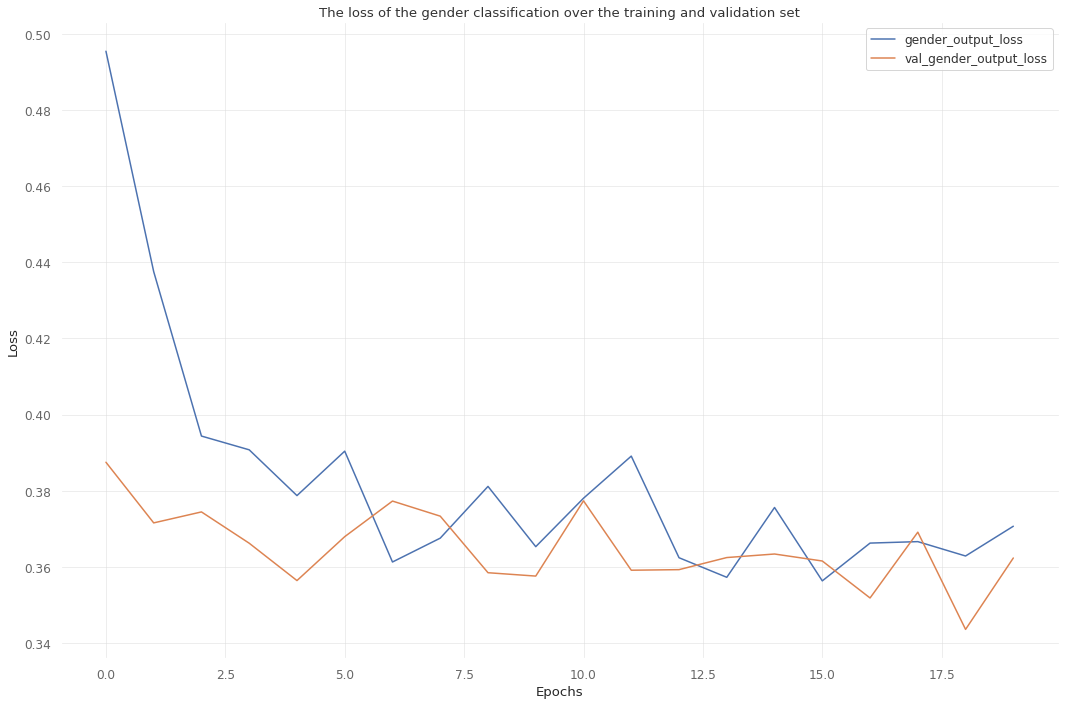

In [56]:
plt.plot(history.history["gender_output_loss"])
plt.plot(history.history["val_gender_output_loss"])
plt.legend(['gender_output_loss', 'val_gender_output_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("The loss of the gender classification over the training and validation set")
plt.tight_layout()

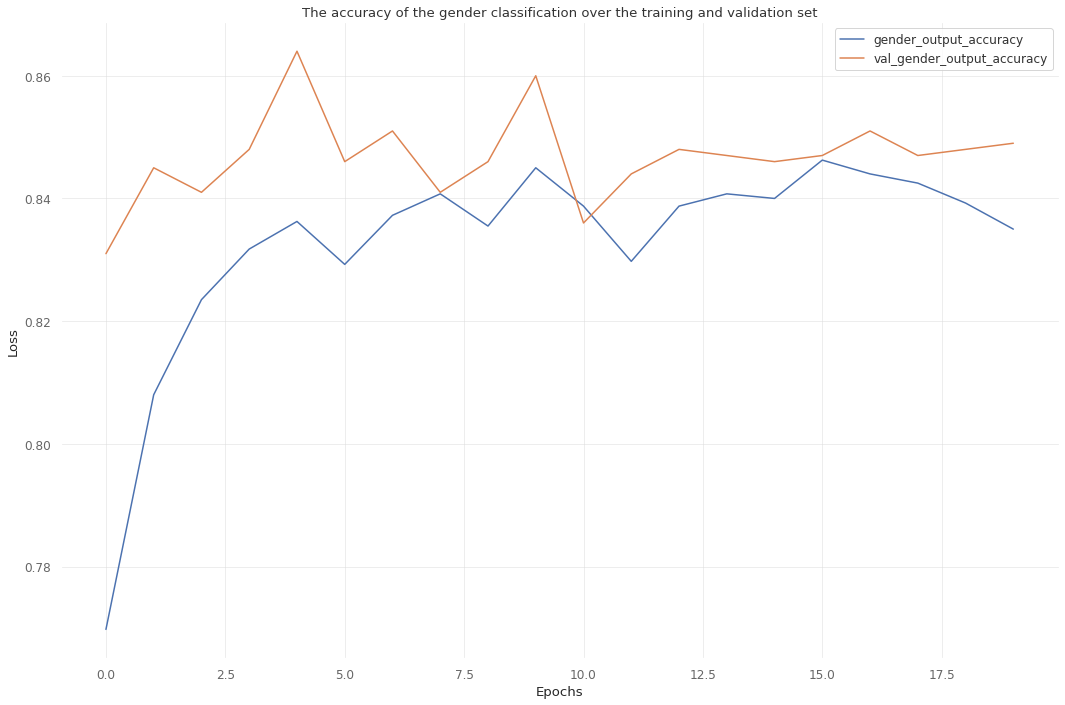

In [57]:
plt.plot(history.history["gender_output_accuracy"])
plt.plot(history.history["val_gender_output_accuracy"])
plt.legend(['gender_output_accuracy', 'val_gender_output_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("The accuracy of the gender classification over the training and validation set")
plt.tight_layout()

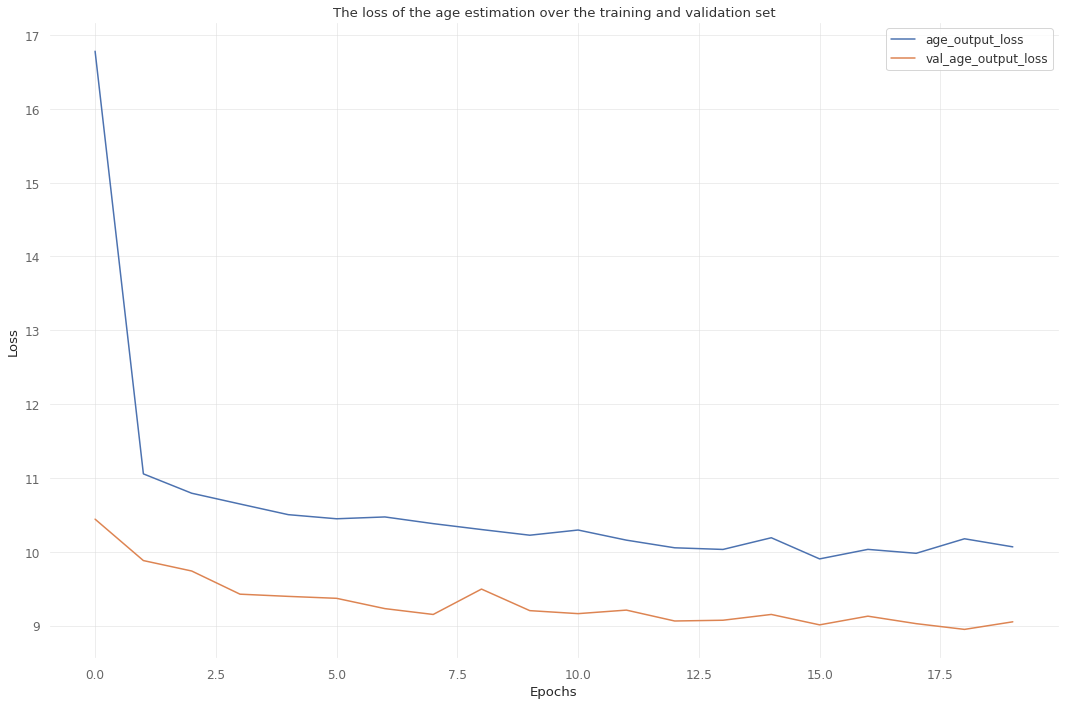

In [58]:
plt.plot(history.history["age_output_loss"])
plt.plot(history.history["val_age_output_loss"])
plt.legend(['age_output_loss', 'val_age_output_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("The loss of the age estimation over the training and validation set")
plt.tight_layout()

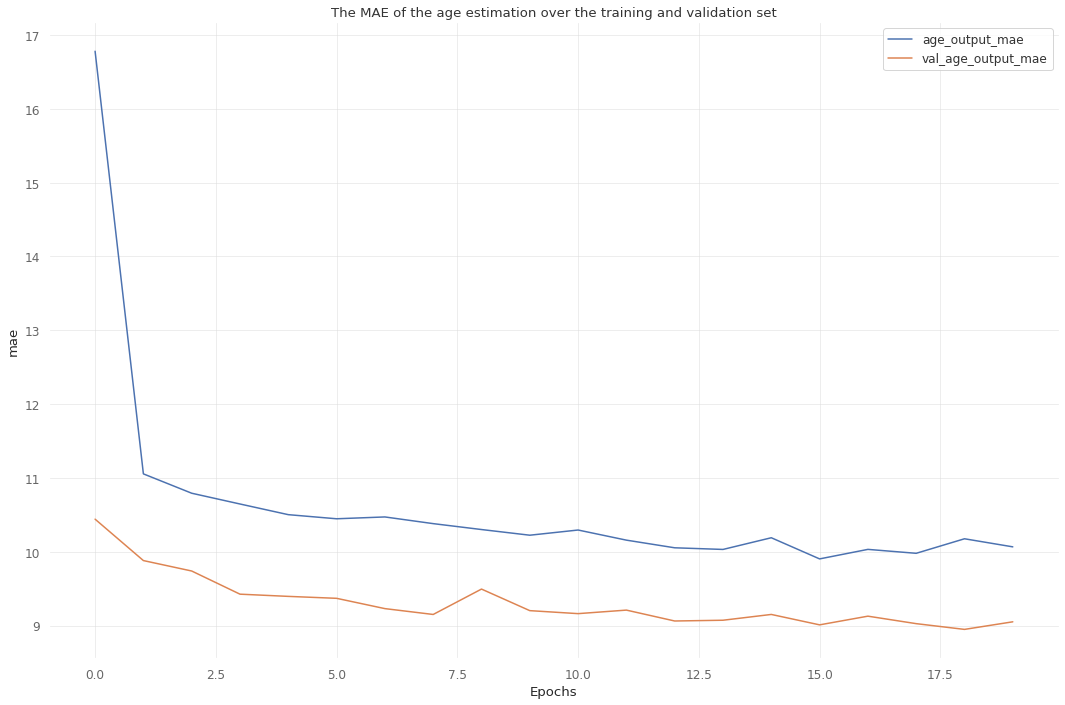

In [59]:
plt.plot(history.history["age_output_mae"])
plt.plot(history.history["val_age_output_mae"])
plt.legend(['age_output_mae', 'val_age_output_mae'])
plt.xlabel("Epochs")
plt.ylabel("mae")
plt.title("The MAE of the age estimation over the training and validation set")
plt.tight_layout()

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#